In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train/train/train.txt
/kaggle/input/train/train/train/treasuryA2.png
/kaggle/input/train/train/train/economist_daily_chart_467.png
/kaggle/input/train/train/train/whoC14_1.png
/kaggle/input/train/train/train/economist_daily_chart_113.png
/kaggle/input/train/train/train/economist_daily_chart_152.png
/kaggle/input/train/train/train/economist_daily_chart_273.png
/kaggle/input/train/train/train/economist_daily_chart_440.png
/kaggle/input/train/train/train/economist_daily_chart_84.png
/kaggle/input/train/train/train/whoO17_2.png
/kaggle/input/train/train/train/economist_daily_chart_16.png
/kaggle/input/train/train/train/whoQ18_4.png
/kaggle/input/train/train/train/economist_daily_chart_168.png
/kaggle/input/train/train/train/wsj527.png
/kaggle/input/train/train/train/economist_daily_chart_333.png
/kaggle/input/train/train/train/whoC19_2.png
/kaggle/input/train/train/train/wsj401.png
/kaggle/input/train/train/train/wsj495.png
/kaggle/input/train/train/train/wsj276.png
/kaggle/i

# Load Dataset

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# Custom DataLoader
import matplotlib.image as mpimg
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2

# model
from torchvision import models
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

# PATHS
TRAIN_PATH = pathlib.Path("/kaggle/input/train/train/train/")
TRAIN_IMP_PATH = pathlib.Path("/kaggle/input/train/train/train_imp/")
TRAIN_TXT_FILEPATH = pathlib.Path("/kaggle/input/train/train/train.txt")
TEST_PATH = pathlib.Path("/kaggle/input/test/test/valid/")
TEST_IMP_PATH = pathlib.Path("/kaggle/input/test/test/valid_imp/")
TEST_TXT_FILEPATH = pathlib.Path("/kaggle/input/test/test/valid.txt")

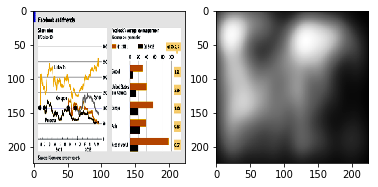

In [3]:
class AttentionPredDataset(Dataset):
    def __init__(self, image_paths, target_paths, text_file, transforms=None):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.text_file = list()
        with open(text_file, "r") as f:
            # text_file doesn't include directory path and extension (.png)
            self.text_file = f.read().splitlines()[:16]
        self.transforms = transforms
    
    def __len__(self):  
        return len(self.text_file)
    
    def __getitem__(self, index):
        image_filename = self.image_paths/(self.text_file[index]+".png")
        target_filename = self.target_paths/(self.text_file[index]+".png")
        image = cv2.imread(str(image_filename))
        target = cv2.imread(str(target_filename))
        sample = {"image": image, "target": target}
        
        if self.transforms:
            sample = self.transforms(sample)
        return sample

class Resize(object):
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        return {'image': cv2.resize(image, (224, 224)),
                'target': cv2.resize(target, (224, 224))}

class GrayScale(object):
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
        return {'image': image, 'target': target}
    
class Normalization(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        
        image = image.astype(np.float64) 
        image /= 255.0
        for i in range(3):
            image[:, :, i] = (image[:, :, i] - self.mean[i]) / self.std[i]
        
        # From paper: load_label()
        target = target.astype(np.float64) 
#         target /= 255.0

        return {'image': image, 'target': target}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'target': torch.from_numpy(target)}

train_dataset = AttentionPredDataset(TRAIN_PATH, TRAIN_IMP_PATH, TRAIN_TXT_FILEPATH, transforms=transforms.Compose([Resize(), 
                                                                                                                    GrayScale(),
                                                                                                                    Normalization(mean=(0.5, 0.5, 0.5), 
                                                                                                                                  std=(0.5, 0.5, 0.5)), 
                                                                                                                    ToTensor()]))
test_dataset = AttentionPredDataset(TEST_PATH, TEST_IMP_PATH, TEST_TXT_FILEPATH, transforms=transforms.Compose([Resize(), 
                                                                                                                    GrayScale(),
                                                                                                                    Normalization(mean=(0.5, 0.5, 0.5), 
                                                                                                                                  std=(0.5, 0.5, 0.5)), 
                                                                                                                    ToTensor()]))
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
data = next(iter(trainloader))
ax1.imshow(data['image'][0].numpy().transpose(1, 2, 0))
ax2.imshow(data['target'][0].numpy(), cmap="Greys_r")
fig.show()

# Model

In [4]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [5]:
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=256):
        super(FCN32s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32,
                                          bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)

        h = self.upscore(h)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())

In [6]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target.long(), weight=weight, reduction='sum')
    if size_average:
        loss /= mask.data.sum()
    return loss

In [7]:
epochs = 50

net = FCN32s()
net.copy_params_from_vgg16(vgg16)
net = net.float() # necessary to avoid error: https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-2-weight/38961/8
criterion = cross_entropy2d
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=10)  # CUDA memory not enough

training_losses = list()
valid_losses = list()

if torch.cuda.is_available():
    net.to('cuda')
    for epoch in tqdm(range(epochs)):
        net.train()
        train_loss = 0
        for data in tqdm(trainloader):
            image = data['image'].float().to('cuda')
            target = data['target'].float().to('cuda')

            optimizer.zero_grad()
            pred = net.forward(image)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.cpu().item()
        
        training_losses.append(train_loss / len(trainloader))
    
        net.eval()
        valid_loss = 0
        for data in testloader:
            image = data['image'].float().to('cuda')
            target = data['target'].float().to('cuda')

            with torch.no_grad():
                pred = net.forward(image)
                loss = criterion(pred, target)
            
            valid_loss += loss.cpu().item()
        valid_losses.append(valid_loss / len(trainloader))
        
#         if not training_losses or train_loss / len(trainloader) < training_losses[-1]:
#             torch.save(net.state_dict(), "fcn32_attn_pred.pkt")
        
        print(f"Epoch {epoch}: \nTrain Loss is {train_loss / len(trainloader):.3f} \nValid Loss is {valid_loss / len(testloader):.3f}")
        

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: 
Train Loss is 5.541 
Valid Loss is 5.531



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: 
Train Loss is 5.520 
Valid Loss is 5.510



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: 
Train Loss is 5.496 
Valid Loss is 5.490



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: 
Train Loss is 5.471 
Valid Loss is 5.462



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: 
Train Loss is 5.436 
Valid Loss is 5.430



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: 
Train Loss is 5.384 
Valid Loss is 5.387



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: 
Train Loss is 5.324 
Valid Loss is 5.319



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: 
Train Loss is 5.234 
Valid Loss is 5.217



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: 
Train Loss is 5.106 
Valid Loss is 5.064



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: 
Train Loss is 4.939 
Valid Loss is 4.965



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: 
Train Loss is 4.863 
Valid Loss is 4.929



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: 
Train Loss is 4.822 
Valid Loss is 4.908



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: 
Train Loss is 4.783 
Valid Loss is 4.891



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: 
Train Loss is 4.751 
Valid Loss is 4.897



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: 
Train Loss is 4.721 
Valid Loss is 4.852



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: 
Train Loss is 4.708 
Valid Loss is 4.842



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: 
Train Loss is 4.700 
Valid Loss is 4.848



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: 
Train Loss is 4.676 
Valid Loss is 4.867



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: 
Train Loss is 4.676 
Valid Loss is 4.849



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: 
Train Loss is 4.647 
Valid Loss is 4.879



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: 
Train Loss is 4.624 
Valid Loss is 4.849



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: 
Train Loss is 4.637 
Valid Loss is 4.862



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: 
Train Loss is 4.593 
Valid Loss is 4.851



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: 
Train Loss is 4.615 
Valid Loss is 4.851



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24: 
Train Loss is 4.607 
Valid Loss is 4.854



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: 
Train Loss is 4.601 
Valid Loss is 4.891



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26: 
Train Loss is 4.589 
Valid Loss is 4.845



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27: 
Train Loss is 4.575 
Valid Loss is 4.857



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28: 
Train Loss is 4.562 
Valid Loss is 4.850



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29: 
Train Loss is 4.555 
Valid Loss is 4.846



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: 
Train Loss is 4.599 
Valid Loss is 4.876



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31: 
Train Loss is 4.553 
Valid Loss is 4.827



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32: 
Train Loss is 4.613 
Valid Loss is 4.885



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33: 
Train Loss is 4.552 
Valid Loss is 4.846



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34: 
Train Loss is 4.542 
Valid Loss is 4.899



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: 
Train Loss is 4.531 
Valid Loss is 4.843



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36: 
Train Loss is 4.513 
Valid Loss is 4.821



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37: 
Train Loss is 4.536 
Valid Loss is 5.010



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38: 
Train Loss is 4.579 
Valid Loss is 4.857



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39: 
Train Loss is 4.529 
Valid Loss is 4.922



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: 
Train Loss is 4.551 
Valid Loss is 4.874



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41: 
Train Loss is 4.501 
Valid Loss is 4.847



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42: 
Train Loss is 4.504 
Valid Loss is 4.846



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43: 
Train Loss is 4.570 
Valid Loss is 5.034



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44: 
Train Loss is 4.545 
Valid Loss is 4.902



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: 
Train Loss is 4.483 
Valid Loss is 4.860



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46: 
Train Loss is 4.486 
Valid Loss is 4.833



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47: 
Train Loss is 4.470 
Valid Loss is 4.879



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48: 
Train Loss is 4.477 
Valid Loss is 4.850



100%|██████████| 50/50 [03:37<00:00,  4.34s/it]

Epoch 49: 
Train Loss is 4.440 
Valid Loss is 4.878


Text(0.5, 1.0, 'Training FCN-32 on 16 Images')

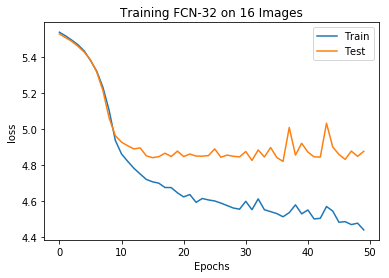

In [8]:
plt.plot(range(len(training_losses)), training_losses, label="Train")
plt.plot(range(len(valid_losses)), valid_losses, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training FCN-32 on 16 Images")

In [9]:
data = next(iter(trainloader))
if torch.cuda.is_available():
    net.eval()
    with torch.no_grad():
        image = data['image'].float().to('cuda')
        pred = net.forward(image).cpu().numpy()

In [10]:
pred = pred.transpose(0, 2, 3, 1)
converted = np.zeros((224, 224))
for i in range(224):
    for j in range(224):
        converted[i, j] = np.argmax(pred[3, 1, 2])
print(converted)

[[34. 34. 34. ... 34. 34. 34.]
 [34. 34. 34. ... 34. 34. 34.]
 [34. 34. 34. ... 34. 34. 34.]
 ...
 [34. 34. 34. ... 34. 34. 34.]
 [34. 34. 34. ... 34. 34. 34.]
 [34. 34. 34. ... 34. 34. 34.]]


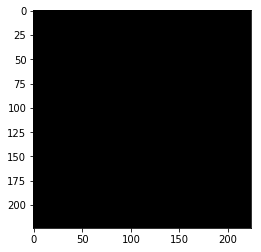

In [11]:
plt.imshow(converted, cmap="Greys_r")